### Imports and data loading.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import datamapplot
import sys
import os
import networkx as nx
sys.path.append(os.path.abspath("/work/home/kdrusci/temporal_grapher"))
import temporal_mapper as tm
import utilities_ as tmutils
import fast_hdbscan ## This is the modified local copy!
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1 import make_axes_locatable

/work/home/kdrusci/.conda/envs/mapper/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [3]:
data_time = np.load("/work/home/kdrusci/mapper-prime/data/dtest_data.npy")
data = data_time[:,0:2]
time = data_time[:,2]
sorted_indices = np.argsort(time)
data = data[sorted_indices]
time = time[sorted_indices]
N_data = np.size(time)

### Constucting the temporal graph

In [7]:
map_data = PCA(n_components=2).fit_transform(data)
y_data = PCA(n_components=1).fit_transform(data)
clusterer = fast_hdbscan.HDBSCAN(min_cluster_size=30)
N_checkpoints = 10
kernel_params = (1),
TG = tm.TemporalGraph(
    time,
    map_data,
    clusterer,
    N_checkpoints = N_checkpoints,
    slice_method='time',
    rate_sensitivity=1,
    kernel = tmutils.square,
    kernel_params = kernel_params,
    verbose=False
)
clusters = TG._cluster()
y_pts = tm.compute_cluster_yaxis(clusters, y_data)
TG.build(y_pts)

### One: Density parameter

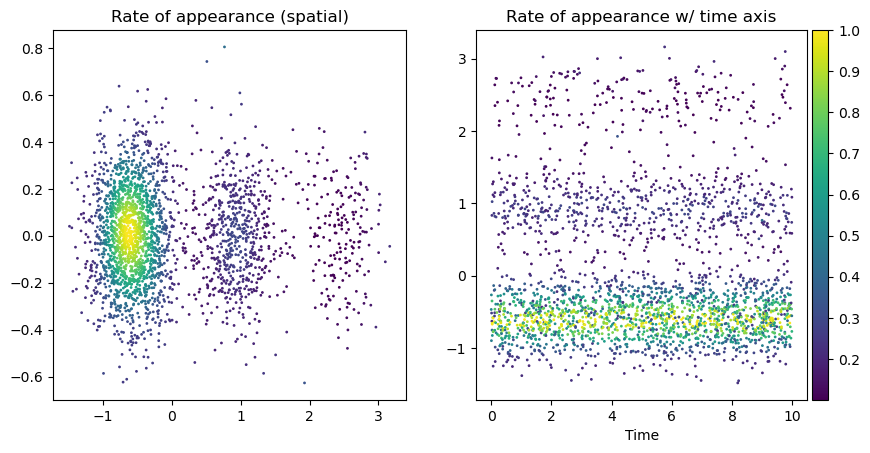

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(10)

ax1.set_title("Rate of appearance (spatial)")
sca=ax1.scatter(map_data[:,0], map_data[:,1],s=1,c=TG.densities)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sca, cax=cax, orientation='vertical')

ax2.scatter(time,y_data,s=1,c=TG.densities)
ax2.set_xlabel("Time")
ax2.set_title("Rate of appearance w/ time axis")
plt.show()

### Two: Pullback of an open ball

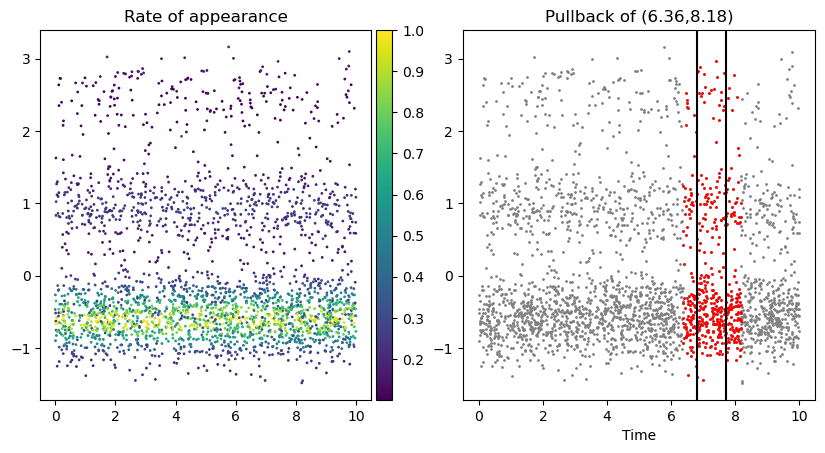

In [9]:
idx=7
TG.add_vertices()
slice_ = (TG.weights[idx] >= 0.01).nonzero()
cp_with_ends = [np.amin(time)]+list(TG.checkpoints)+[np.amax(time)]
bin_width = (cp_with_ends[idx+1]-cp_with_ends[idx])
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
ax1.set_title("Rate of appearance")
sca=ax1.scatter(time,y_data,s=1,c=TG.densities)
ax2.scatter(time,y_data,s=1,c='grey')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sca, cax=cax, orientation='vertical')
ax2.scatter(time[slice_],y_data[slice_],s=1,c='red')
tstr = f'Pullback of ({TG.checkpoints[idx]-bin_width:.2f},{TG.checkpoints[idx]+bin_width:.2f})'
ax2.set_title(tstr)
ax2.set_xlabel("Time")
ax2.axvline(TG.checkpoints[idx]+bin_width/2,c='k')
ax2.axvline(TG.checkpoints[idx]-bin_width/2,c='k')
plt.show()

### Three: Width of widest and narrowest points

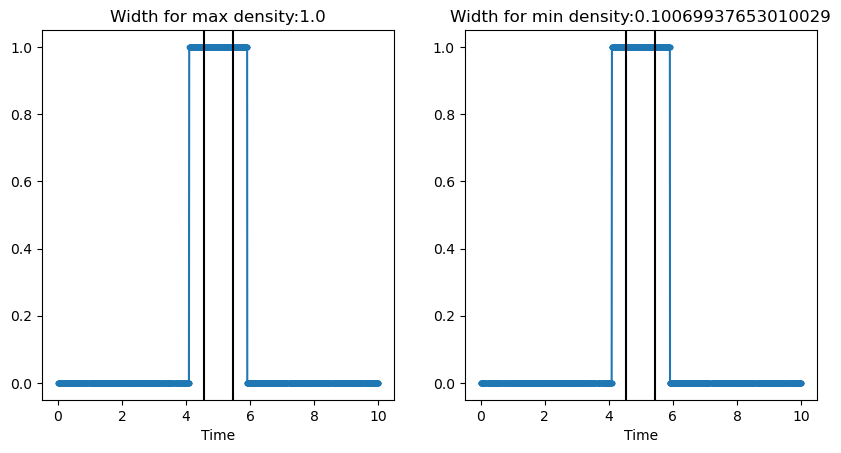

In [10]:
t0=5
dmin = np.amin(TG.densities)
dmax = np.amax(TG.densities)
bin_width = (cp_with_ends[idx+1]-cp_with_ends[idx])

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
ax1.set_title("Width for max density:"+str(dmax))
ax1.plot(time,TG.kernel(t0,time,dmax,bin_width,params=kernel_params),marker='.')
ax1.set_xlabel("Time")

ax2.plot(time,TG.kernel(t0,time,dmin,bin_width,params=kernel_params),marker='.')
ax2.set_title("Width for min density:"+str(dmin))
ax2.set_xlabel("Time")
for ax in (ax1,ax2):
    ax.axvline(t0+bin_width/2,c='k')
    ax.axvline(t0-bin_width/2,c='k')
plt.show()